# NAO Recognizes Dancesport Music

This project aims, to teach robot NAO recoginze various dancesport music. 

Dancesport denotes competitive ballroom dancing, as contrasted to social or exhibition dancing.

There is a similar project [Nao - trénujeme na Stardance](https://moodle.fit.cvut.cz/mod/page/view.php?id=62669),
which implements one dance move - ChaCha and tryies to catch the rhytm from clapping hands.

However, I wasn't able to see if the implementation really works, since the source code for this project is not available anymore.

Furthermore, it is really tedious process to manually set robot for a specific dance and give robot a tempo by clapping hands.
This project aims to narrow the gap for NAO robot to be able to recognize the music automatically and start dancing without any user interaction, by listening to music, choosing a right dance and start dancing to an upbeat.

## Pipeline
1. Offline model training
    * Music collection (10 types of dances)
    * Music feature extraction
    * Model training
2. Connecting and interfering with NAO robot
    * Using NAO microphone to collect a short audio sample
    * Send to Neural Network (embdedded in NAO or remote)
3. Get music genre prediction/tempo
4. Start dancing


## Music introduction
Dancesport music genres consists of Latin and Standard dances:
* These are: ChaCha, Rumba, Jive, Paso Doble, Samba, Waltz, Vienesse Waltz, Slowflox, QuickStep, and Tango
* Song may be different but typically share the same tempo and specific accent on various beats in music
* We need to classify the dance in these 10 classes and then find out the tempo so robot can adapt to the speed of music to dance


## Importing python libraries

In [48]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import random
import glob
import itertools
from tqdm import tqdm

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib 

#Keras
import keras
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, concatenate, Average
from keras.models import model_from_json

import sounddevice as sd
from scipy.io.wavfile import write
import operator
from IPython.display import display
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

## Feature extraction
Audio raw file are not easy to work with
* We can use feature extraction and try to find features which separates the classes
* Intuitive features in music would be: Speed, Volume, Mood, Length, etc..
* We can also use more “low-level” features such as
Chroma, spectral rolloff, spectral centroid, mel-frequency, etc
These features will form the vectors (float matrix) which we use to train on


In [11]:
genres = ['cha_cha', 'jive', 'paso_doble', 'quickstep', 'rumba', 'samba', 'slowfox', 'tango', 'viennese_waltz', 'waltz']

In [12]:
# get names of genres from folder structure
genres = os.listdir("music")

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [13]:
def augment_and_normalize_audio(data):
    
    noise = np.random.randn(len(data))
    augmented_data = data + 0.005 * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    
    norm_data = librosa.util.normalize(augmented_data)
    
    return norm_data

In [14]:
def get_features(y, sr):
    feature_list = []
    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    feature_list = [np.mean(chroma_stft), np.mean(rmse), np.mean(spec_cent),
                    np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
    for e in mfcc:
        feature_list.append(np.mean(e))
    return np.array(feature_list)

In [15]:
csv_filename = "data_5s.csv"

In [ ]:
file = open(csv_filename, 'w', newline='', encoding='utf-8')
with file:
    writer = csv.writer(file)
    writer.writerow(header)


for g in genres:
    print(f"Processing: {g}") 
    for filename in os.listdir(f'./music/{g}'):
        songname = f'./music/{g}/{filename}'
        extension = os.path.splitext(songname)[1]
        if extension in [".mp3", ".wav"]:
            
            # get 4 x 5s samples from each song
            random_three_offsets = [random.uniform(5.0, 10.0) + 10*x for x in range(4)]
            for random_offset in random_three_offsets:
                try:
                    y, sr = librosa.load(songname, mono=True, offset=random_offset, duration=5)
                except:
                    continue
                
                y = augment_and_normalize_audio(y)

                filename_cleaned = "".join([x if x != " " else "_" for x in filename])
                # to_append = f'{filename_cleaned},'
                to_append = ''
                f = get_features(y, sr)
                to_append += ','.join(("%.5f" % x) for x in f)
                to_append += f',{g}'
                file = open(csv_filename, 'a', newline='', encoding='utf-8')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())
                    
print("\nProcessing has finished!")

# Analysing the Data in Pandas
* Total of 28 columns
* First = filename (useless)
* Last = label (music genre)
* 26 = features
My own database of dance music
contains 1049 songs






In [32]:
data = pd.read_csv(csv_filename, encoding="utf-8")
data.head()

chroma_stft     rmse  spectral_centroid  spectral_bandwidth     rolloff  \
0      0.38748  0.15494         2720.81857          2758.11725  5777.77710   
1      0.35087  0.18343         2543.87202          2612.72609  5209.78902   
2      0.39375  0.15886         2581.52304          2700.20902  5489.82035   
3      0.26433  0.17843         2073.35691          2597.62530  4550.58390   
4      0.50579  0.17477         3588.63179          2772.30389  6776.32955   

   zero_crossing_rate     mfcc1     mfcc2     mfcc3     mfcc4   ...     \
0             0.10671 -61.43106  68.08979   2.67463  37.46628   ...      
1             0.10886 -41.43826  75.78372  -7.46555  38.61356   ...      
2             0.10185 -55.56802  74.85971  -3.04822  35.88836   ...      
3             0.06948 -98.73599  93.40114  10.20151  22.76788   ...      
4             0.20418 -68.91948  35.47957   8.75957  28.32708   ...      

    mfcc12   mfcc13   mfcc14   mfcc15   mfcc16   mfcc17   mfcc18   mfcc19  \
0  3.99809 -0.42287  0.75676 -1.22858 -1.73335 -6.39568  0.51037 -1.46026   
1  1.31851 -0.62016 -0.35987 -1.55587 -0.79349 -7.32282 -2.45229 -4.03709   
2  2.25581 -2.36017 -2.17532 -1.92595 -0.38117 -5.13405  0.29986 -2.31581   
3 -2.47789 -5.80070 -3.43616 -1.12958  0.69015  2.64838  7.32227  3.42984   
4  9.89691  2.91256  7.70387  0.54494  7.06017  0.99529  3.09879 -2.35246   

    mfcc20    label  
0 -0.23798  cha_cha  
1  0.10715  cha_cha  
2 -0.69723  cha_cha  
3  3.50405  cha_cha  
4  3.54246  cha_cha  

[5 rows x 27 columns]

In [33]:
data.shape

(4237, 27)

# Encoding the Labels
We need to encode the labels - e.g. to integers

Another possibility is *one-hot-encoding*

In [39]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
joblib.dump(encoder, 'encoder.pkl', protocol=2) 

['encoder.pkl']

In [34]:
encoder = joblib.load("encoder.pkl")

In [35]:
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
le_name_mapping

{0: 'cha_cha',
 1: 'jive',
 2: 'paso_doble',
 3: 'quickstep',
 4: 'rumba',
 5: 'samba',
 6: 'slowfox',
 7: 'tango',
 8: 'viennese_waltz',
 9: 'waltz'}

# Scaling the Feature columns
It's also a good idea to normalize = scale the data  
so there are no exteremes across different attributes

In [36]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
joblib.dump(scaler, 'scaler.pkl',protocol=2) 

['scaler.pkl']

In [37]:
np.array(data.iloc[:, :-1], dtype = float).shape

(4237, 26)

# Dividing data into training and Testing set
When training, we normally use tree subsets:
* **Training set** - used for training
* **Validation set** - used for validation after each epoch set
* **Testing set** - to test the model accuracy on never-befer seen data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
len(y_train)

X_val = X_train[:800]
X_train = X_train[800:]

y_val = y_train[:800]
y_train = y_train[800:]

# Classification with Keras

## Building our Network
Building the network can be really tedious sometimes.

It requires lot of tuning and experimenting.
For **regularization** we can use *Dropout*

To further prevent model from *overfitting* we can also **Early stop** it,
after we see no improvement after a specified patience

In [502]:
weight_num = 3
weight_file = os.path.join("weights_{}.h5".format(weight_num))

es = EarlyStopping(monitor="val_acc", mode='max', patience=10)
checkpoint = ModelCheckpoint(weight_file, monitor='val_acc',
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint, es]

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=16,
          callbacks=callbacks_list,
          validation_data=(X_val, y_val))

Train on 3013 samples, validate on 800 samples
Epoch 1/50
3013/3013 [==============================] - 3s 972us/step - loss: 1.9594 - acc: 0.2791 - val_loss: 1.8367 - val_acc: 0.3412
Epoch 2/50
3013/3013 [==============================] - 1s 464us/step - loss: 1.7766 - acc: 0.3558 - val_loss: 1.7128 - val_acc: 0.4037
Epoch 3/50
3013/3013 [==============================] - 1s 461us/step - loss: 1.6682 - acc: 0.4109 - val_loss: 1.6679 - val_acc: 0.4162
Epoch 4/50
3013/3013 [==============================] - 2s 500us/step - loss: 1.5818 - acc: 0.4295 - val_loss: 1.6140 - val_acc: 0.4225
Epoch 5/50
3013/3013 [==============================] - 2s 500us/step - loss: 1.5289 - acc: 0.4530 - val_loss: 1.5749 - val_acc: 0.4600
Epoch 6/50
3013/3013 [==============================] - 1s 496us/step - loss: 1.4627 - acc: 0.4663 - val_loss: 1.5272 - val_acc: 0.4650
Epoch 7/50
3013/3013 [==============================] - 2s 509us/step - loss: 1.4193 - acc: 0.4812 - val_loss: 1.5340 - val_acc: 0.4550
E

### Save model to disk

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Load model from disk

In [41]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                1728      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_48 (Dense)             (None, 10)                5130      
Total params: 155,082
Trainable params: 155,082
Non-trainable params: 0
_________________________________________________________________


We can save and load best trained weights,  
so we don't need to train model again

In [42]:
model.load_weights("weights_3.h5")
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss="sparse_categorical_crossentropy", # f1_loss
              optimizer="adam",
              metrics=['accuracy'])

## Evaluating model
Now we can evaluate the model on test data, which we set apart before.  
Also, we can use model to predict data, and then compare predictions
with all other classes and construct a so-called **confusion matrix**.

This matrix can tell us, which class model confuses the most and what  
is the class that it confuses it for.

In [43]:
results = model.evaluate(X_test, y_test)
print(results)

424/424 [==============================] - 0s 365us/step
[0.49132803440937456, 0.8867924528301887]


In [44]:
predictions = model.predict_classes(X_test)
predictions

array([7, 9, 9, 4, 3, 6, 5, 4, 6, 5, 4, 8, 2, 9, 9, 3, 3, 0, 3, 8, 2, 3,
       7, 6, 3, 3, 9, 1, 0, 6, 9, 8, 5, 0, 6, 3, 0, 2, 4, 3, 8, 6, 5, 3,
       9, 3, 7, 0, 9, 7, 7, 6, 0, 3, 7, 4, 3, 3, 3, 7, 9, 8, 8, 0, 2, 0,
       5, 3, 4, 3, 5, 2, 9, 4, 7, 7, 9, 5, 7, 8, 9, 5, 3, 6, 6, 4, 9, 9,
       1, 9, 4, 5, 8, 8, 6, 9, 4, 4, 4, 4, 3, 6, 6, 1, 3, 0, 6, 9, 7, 2,
       5, 5, 0, 3, 5, 3, 4, 9, 4, 2, 0, 0, 5, 0, 9, 3, 1, 4, 9, 7, 8, 2,
       8, 8, 3, 6, 0, 1, 0, 9, 6, 1, 8, 8, 8, 0, 9, 6, 3, 8, 0, 4, 8, 7,
       8, 1, 6, 5, 7, 9, 9, 5, 9, 9, 2, 0, 8, 4, 3, 4, 3, 0, 7, 6, 3, 0,
       2, 0, 5, 3, 3, 6, 4, 9, 7, 5, 7, 8, 0, 2, 1, 6, 6, 4, 5, 4, 8, 5,
       7, 1, 2, 7, 8, 6, 2, 8, 3, 1, 7, 9, 3, 3, 2, 0, 1, 7, 8, 7, 8, 7,
       8, 1, 8, 6, 6, 9, 0, 9, 5, 8, 7, 7, 2, 5, 7, 8, 6, 3, 7, 1, 5, 6,
       6, 8, 0, 4, 5, 4, 4, 9, 4, 2, 5, 9, 5, 9, 9, 3, 3, 6, 0, 2, 9, 5,
       6, 6, 1, 9, 9, 6, 7, 9, 9, 9, 7, 1, 5, 5, 1, 7, 3, 1, 9, 8, 0, 0,
       8, 7, 7, 5, 6, 9, 9, 0, 0, 7, 8, 9, 5, 2, 8,

In [45]:
cm = confusion_matrix(y_test, predictions)
model_name = "Music genres classification"

In [46]:
def plot_and_save_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation="horizontal", pad=0.14, shrink=0.5)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:d}".format(int(cm[i, j] * 100)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:d}".format(int(cm[i, j] * 100)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color="black")
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), color="black")
    
    plt.savefig('outputs/conf_matrix_{}.pdf'.format(model_name))
    plt.show()

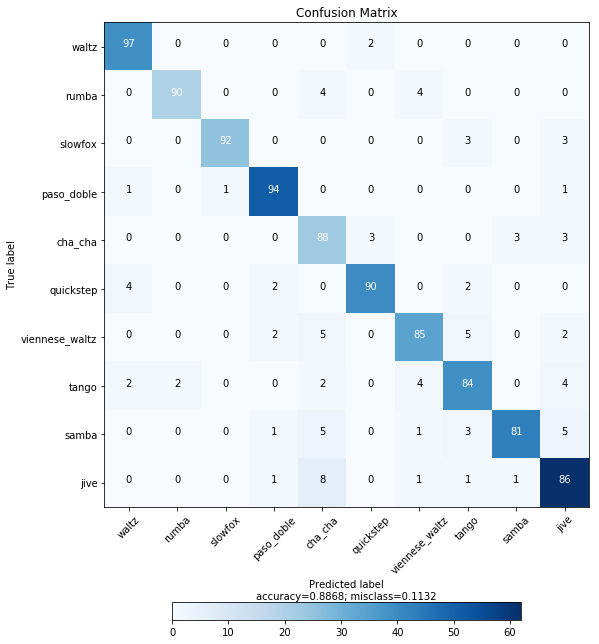

In [47]:
plot_and_save_confusion_matrix(cm, genres, title="Confusion Matrix")

## Possible enhancements
* Learn robot at least one choreography for each dance
* Get more data -> obtain better accuracy
* Start dancing at downbeat of the music phrase (sync)
* Expand to more music genres (not only dancesport limited)
* Pair dancing? :)


## Testing on custom songs
Let's test my 3 favourite songs for Cha-Cha, Samba and Waltz

In [49]:
def predict_genre(songname, offset=0):
    y, sr = librosa.load(songname, mono=True, offset=offset, duration=10)
    
    norm_data = librosa.util.normalize(y)
    display(ipd.Audio(norm_data, rate=sr)) # show play
    
    f = get_features(norm_data, sr).reshape(1, -1)
    X = scaler.transform(f)

    p = [(le_name_mapping[i],score) for (i,score) in enumerate(model.predict(X)[0])]
    for k,v in sorted(p, key=operator.itemgetter(1), reverse=True):
        print(k, "->", v)
    
    predictions = model.predict_classes(X)
    return encoder.inverse_transform(predictions[0])

In [50]:
predict_genre("test_music/WALTZ_Sad_Romance_29bpm.mp3", 15)

waltz -> 0.6068398
tango -> 0.38993973
viennese_waltz -> 0.0010131991
slowfox -> 0.0008672212
quickstep -> 0.00076284475
cha_cha -> 0.00028128357
rumba -> 0.000275695
paso_doble -> 1.2908786e-05
jive -> 6.413268e-06
samba -> 9.129693e-07


'waltz'

In [51]:
predict_genre("test_music/CHACHA_Tacata_31bpm.mp3", 10)

cha_cha -> 0.9317366
samba -> 0.048064463
jive -> 0.010555894
tango -> 0.006175278
paso_doble -> 0.0026944045
slowfox -> 0.0006331845
quickstep -> 0.00013429536
viennese_waltz -> 5.2822265e-06
rumba -> 6.014148e-07
waltz -> 8.6006054e-08


'cha_cha'

In [61]:
predict_genre("test_music/SAMBA_Im_Into_You_48bpm.mp3", 40)

samba -> 0.51477134
cha_cha -> 0.46433392
tango -> 0.015129227
quickstep -> 0.0022039511
jive -> 0.001922058
slowfox -> 0.0008181634
paso_doble -> 0.0005152458
rumba -> 0.00017351717
viennese_waltz -> 0.00013246146
waltz -> 1.5033939e-07


'samba'

**All 3 songs were correctly classified!**

## Record from microphone and recognize

In [60]:
fs = 44100  # Sample rate
seconds = 5  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file 
predict_genre("output.wav")

quickstep -> 0.50737715
cha_cha -> 0.33227858
slowfox -> 0.111520134
tango -> 0.03699005
samba -> 0.0062116967
paso_doble -> 0.004630519
viennese_waltz -> 0.0005865309
jive -> 0.00032740255
waltz -> 7.7803794e-05
rumba -> 1.16463355e-07


'quickstep'